<a href="https://colab.research.google.com/github/reshalfahsi/neural-machine-translation/blob/master/EN_DE_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **English-To-German Neural Machine Translation Using Transformer**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics torchtext spacy
!python -q -m spacy download en
!python -q -m spacy download de

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 281.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 236.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 253.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 186.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 214.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.0/364.0 kB 200.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 140.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 152.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 147.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 166.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 169.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

### **Import**

In [87]:
try:
    import lightning as L
except:
    import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics.text import TranslationEditRate

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from typing import Tuple
from torch import Tensor

import io
import os
import re
import cv2
import math
import string
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [88]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

HID_DIM = 360
ENC_HEADS = 8
DEC_HEADS = 8
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_PF_DIM = 690
DEC_PF_DIM = 690
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

MAX_EPOCH = 60
BATCH_SIZE = 128
LR = 7.5e-3
CHECKPOINT_DIR = os.getcwd()

MAX_SEQUENCE = 42

## **Dataset**

### **Download**

In [89]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.en.gz', 'train.de.gz')
val_urls = ('val.en.gz', 'val.de.gz')
test_urls = ('test_2016_flickr.en.gz', 'test_2016_flickr.de.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

### **Utils**

In [90]:
de_tokenizer = get_tokenizer("spacy", language="de")
en_tokenizer = get_tokenizer("spacy", language="en")


def build_vocab(filepaths, tokenizer):
    counter = Counter()
    for filepath in filepaths:
        with io.open(filepath, encoding="utf8") as f:
            for string_ in f:
                string_ = (
                    string_.lower()
                    .translate(str.maketrans("", "", string.punctuation))
                    .replace(" \n", " ")
                    .replace("\n ", " ")
                    .replace("\n", " ")
                    .replace(" “", " ")
                    .replace("“ ", " ")
                    .replace("“", "")
                )
                counter.update(tokenizer(string_))
    voc = vocab(counter, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
    voc.set_default_index(voc["<unk>"])
    return voc


de_vocab = build_vocab(
    [train_filepaths[1]] + [val_filepaths[1]] + [test_filepaths[1]],
    de_tokenizer,
)
en_vocab = build_vocab(
    [train_filepaths[0]] + [val_filepaths[0]] + [test_filepaths[0]],
    en_tokenizer,
)


def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[1], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[0], encoding="utf8"))
    data = []
    for raw_en, raw_de in zip(raw_en_iter, raw_de_iter):
        raw_en = (
            raw_en.lower()
            .translate(str.maketrans("", "", string.punctuation))
            .replace(" \n", " ")
            .replace("\n ", " ")
            .replace("\n", " ")
            .replace(" “", " ")
            .replace("“ ", " ")
            .replace("“", "")
        )
        raw_de = (
            raw_de.lower()
            .translate(str.maketrans("", "", string.punctuation))
            .replace(" \n", " ")
            .replace("\n ", " ")
            .replace("\n", " ")
            .replace(" “", " ")
            .replace("“ ", " ")
            .replace("“", "")
        )

        de_tensor_ = torch.tensor(
            [de_vocab[token] for token in de_tokenizer(raw_de)], dtype=torch.long
        )
        en_tensor_ = torch.tensor(
            [en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long
        )
        data.append((en_tensor_, de_tensor_))
    return data


TrainDataset = data_process(train_filepaths)
ValDataset = data_process(val_filepaths)
TestDataset = data_process(test_filepaths)

In [91]:
def generate_batch(data_batch):
    de_batch, en_batch = [], []
    for en_item, de_item in data_batch:
        de_batch.append(
            torch.cat(
                [torch.tensor([de_vocab['<bos>']]), de_item, torch.tensor([de_vocab['<eos>']])], dim=0
            )
        )
        en_batch.append(
            torch.cat(
                [torch.tensor([en_vocab['<bos>']]), en_item, torch.tensor([en_vocab['<eos>']])], dim=0
            )
        )

    de_batch.append(torch.randn(MAX_SEQUENCE + 1))
    de_batch = pad_sequence(
        de_batch,
        batch_first=True,
        padding_value=de_vocab['<pad>'],
    )[:-1, ...]

    en_batch.append(torch.randn(MAX_SEQUENCE))
    en_batch = pad_sequence(
        en_batch,
        batch_first=True,
        padding_value=en_vocab['<pad>'],
    )[:-1, ...]
    return en_batch, de_batch

In [92]:
OUTPUT_DIM = len(de_vocab)
INPUT_DIM = len(en_vocab)

print("Input dimension:", INPUT_DIM)
print("Output dimension:", OUTPUT_DIM)

Input dimension: 10493
Output dimension: 19184


## **Model**

In [93]:
class AvgMeter(object):
    def __init__(self, num=40):
        self.num = num
        self.reset()

    def reset(self):
        self.scores = []

    def update(self, val):
        self.scores.append(val)

    def show(self):
        out = torch.mean(
            torch.stack(
                self.scores[np.maximum(len(self.scores)-self.num, 0):]
            )
        )
        return out

In [94]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)

        # attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        # x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        # x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        # x = [batch size, query len, hid dim]

        return x, attention

In [95]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        # x = [batch size, seq len, hid dim]

        return x

In [96]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(
            hid_dim, pf_dim, dropout
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src = [batch size, src len, hid dim]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        # positionwise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        return src

In [97]:
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim,
        hid_dim,
        n_layers,
        n_heads,
        pf_dim,
        dropout,
        device,
        max_length=100,
    ):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList(
            [
                EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                for _ in range(n_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = (
            torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        )

        # pos = [batch size, src len]

        src = self.dropout(
            (self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)
        )

        # src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        # src = [batch size, src len, hid dim]

        return src

In [98]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(
            hid_dim, n_heads, dropout, device
        )
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(
            hid_dim, pf_dim, dropout
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg = [batch size, trg len, hid dim]

        # encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg = [batch size, trg len, hid dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]

        return trg, attention

In [99]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        hid_dim,
        n_layers,
        n_heads,
        pf_dim,
        dropout,
        device,
        max_length=100,
    ):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList(
            [
                DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                for _ in range(n_layers)
            ]
        )

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = (
            torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        )

        # pos = [batch size, trg len]

        trg = self.dropout(
            (self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)
        )

        # trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        # output = [batch size, trg len, output dim]

        return output, attention

In [100]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)

        # src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):
        # trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(
            torch.ones((trg_len, trg_len), device=self.device)
        ).bool()

        # trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):
        # src = [batch size, src len]
        # trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        # enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]

        return output, attention

In [101]:
MODEL = Seq2Seq
MODEL_NAME = MODEL.__name__

In [102]:
class ModelWrapper(L.LightningModule):
    def __init__(self, arch, batch_size, lr, max_epoch):
        super().__init__()

        self.arch = arch
        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.test_ter = TranslationEditRate()

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self._device = "cpu" if not torch.cuda.is_available() else "cuda"

    def forward(self, x, y):
        return self.arch(x, y)

    def translate_sentence(self, sentence, max_len = MAX_SEQUENCE):

        self.eval()

        if isinstance(sentence, str):
            tokens = [token.lower() for token in en_tokenizer(sentence)]
        else:
            tokens = [token.lower() for token in sentence]
        tokens = ["<bos>"] + tokens + ["<eos>"]
        tokens = tokens + ["<pad>"] * (max_len - len(tokens))
        src_indexes = [en_vocab[token] for token in tokens]
        src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(self._device)
        src_mask = self.arch.make_src_mask(src_tensor)

        enc_src = self.arch.encoder(src_tensor, src_mask)

        trg_indexes = [de_vocab["<bos>"]] + [de_vocab["<pad>"]] * (max_len - 1)
        stop_index = -1
        for i in range(1, max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(self._device)
            trg_mask = self.arch.make_trg_mask(trg_tensor)
            output, attention = self.arch.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            pred_token = F.softmax(output, dim=-1).argmax(2)[:,-1].item()
            trg_indexes[i] = pred_token
            stop_index = i
            if pred_token == de_vocab["<eos>"]:
                break
        trg_tokens = [de_vocab.lookup_token(i) for i in trg_indexes]
        return trg_tokens[1:stop_index+1], attention

    def translate_tensor(self, input_tensor, language="de"):
        if language=="en":
            return self.translate_sentence([en_vocab.lookup_token(i) for i in input_tensor])
        elif language=="de":
            input_tensor = torch.argmax(F.softmax(input_tensor, dim=-1), dim=-1)
            return " ".join([de_vocab.lookup_token(i) for i in input_tensor])

    def training_step(self, batch, batch_nb):
        x_en, x_de = batch
        x_hat, _ = self(x_en, x_de[:, :-1])

        x_hat_shape = x_hat.shape
        x_hat = x_hat.view(-1, x_hat_shape[-1])
        x_de = x_de[:, 1:].reshape(x_de.shape[0] * (x_de.shape[-1] - 1))

        PAD_IDX = de_vocab['<pad>']
        loss = F.cross_entropy(x_hat, x_de, ignore_index=PAD_IDX)

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        torch.nn.utils.clip_grad_norm_(self.parameters(), 1.)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.train_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x_en, x_de = batch
        x_hat, _ = self(x_en, x_de[:, :-1])

        x_hat_shape = x_hat.shape
        x_hat = x_hat.view(-1, x_hat_shape[-1])
        x_de = x_de[:, 1:].reshape(x_de.shape[0] * (x_de.shape[-1] - 1))

        PAD_IDX = de_vocab['<pad>']
        loss = F.cross_entropy(x_hat, x_de, ignore_index=PAD_IDX)

        self.log("val_loss", loss, prog_bar=True)
        self.val_loss_recorder.update(loss.data)

    def on_validation_epoch_end(self):
        val_loss = self.val_loss_recorder.show().data.cpu().numpy()
        self.val_loss.append(val_loss)
        self.val_loss_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        x_en, x_de = batch
        x_hat, _ = self(x_en, x_de[:, :-1])

        x_hat_shape = x_hat.shape
        x_hat = x_hat.view(-1, x_hat_shape[-1])
        x_de = x_de[:, 1:].reshape(x_de.shape[0] * (x_de.shape[-1] - 1))

        PAD_IDX = de_vocab['<pad>']
        loss = F.cross_entropy(x_hat, x_de, ignore_index=PAD_IDX)

        ter = torch.tensor(0.0)
        ############### Translating Time ###############
        x_hat = x_hat.view(x_hat_shape[0], x_hat_shape[1], x_hat_shape[2])
        x_de = x_de.view(x_hat_shape[0], x_hat_shape[1])
        for b in range(x_hat_shape[0]):
            x_ = self.translate_tensor(x_hat[b, :, :])
            x = list()
            x.append(" ".join([de_vocab.lookup_token(i) for i in x_de[b]]))

            self.test_ter.update(x_, x)
            ter += self.test_ter.compute().data.cpu()
        ################################################
        ter /= x_hat_shape[0]

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_ter", ter, prog_bar=True, logger=True)

    def on_train_end(self):
        # Loss
        loss_img_file = f"/content/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            collate_fn=generate_batch,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            collate_fn=generate_batch,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            collate_fn=generate_batch,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
            betas=(0.9, 0.98),
            eps=1e-9,
        )
        step_factor = math.sqrt(self.max_epoch)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[
                    int(self.max_epoch * idx / step_factor)
                    for idx in range(int(step_factor) - 1)
                ],
                gamma=1 / step_factor,
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

## **Training**

In [103]:
SEED = int(np.random.randint(2147483647))

print(f"Random seed: {SEED}")

Random seed: 1577631178


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/lightning_logs/

INFO: Global seed set to 1577631178
INFO: Global seed set to 1577631178
INFO:lightning.fabric.utilities.seed:Global seed set to 1577631178
INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

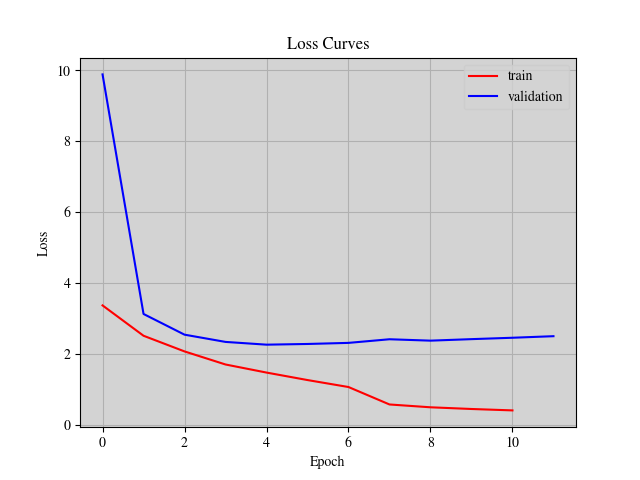

<Figure size 640x480 with 0 Axes>

In [104]:
seed_everything(SEED, workers=True)

ENC = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              DEVICE)

DEC = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              DEVICE)

SRC_PAD_IDX = en_vocab["<pad>"]
TGT_PAD_IDX = de_vocab["<pad>"]

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model = MODEL(ENC, DEC, SRC_PAD_IDX, TGT_PAD_IDX, DEVICE)

model.apply(initialize_weights)

model = ModelWrapper(model, BATCH_SIZE, LR, MAX_EPOCH).to(DEVICE)

tensorboardlogger = TensorBoardLogger(save_dir="logs/")
csvlogger = CSVLogger(save_dir="logs/")
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    dirpath=CHECKPOINT_DIR,
    filename=f"{MODEL_NAME}_best",
    mode='min',
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=int(math.sqrt(MAX_EPOCH)),
    verbose=False,
    mode="min",
)

trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCH,
    logger=[tensorboardlogger, csvlogger],
    callbacks=[lr_monitor, checkpoint, early_stopping],
    log_every_n_steps=5,
)
trainer.fit(model)

## **Testing**

In [105]:
os.rename(
    checkpoint.best_model_path,
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")
)

In [106]:
trainer.test(ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"))

INFO: Restoring states from the checkpoint path at /content/Seq2Seq_best.ckpt
INFO: Restoring states from the checkpoint path at /content/Seq2Seq_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/Seq2Seq_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/Seq2Seq_best.ckpt
INFO: Loaded model weights from the checkpoint at /content/Seq2Seq_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/Seq2Seq_best.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.07562255859375      │
│         test_ter          │    0.8236252069473267     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.07562255859375, 'test_ter': 0.8236252069473267}]

## **Inference**

In [305]:
INPUT_SENTENCE = "A son has a house and a money"  # @param {type:"string"}

############################# __main__ #############################
ENC = Encoder(
    INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, DEVICE
)

DEC = Decoder(
    OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, DEVICE
)

SRC_PAD_IDX = en_vocab["<pad>"]
TGT_PAD_IDX = de_vocab["<pad>"]
model = ModelWrapper.load_from_checkpoint(
    checkpoint_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),
    map_location=DEVICE,
    arch=MODEL(ENC, DEC, SRC_PAD_IDX, TGT_PAD_IDX, DEVICE),
    batch_size=BATCH_SIZE,
    lr=LR,
    max_epoch=MAX_EPOCH,
)

INPUT_SENTENCE = (
    INPUT_SENTENCE.lower()
    .translate(str.maketrans("", "", string.punctuation))
    .replace(" \n", " ")
    .replace("\n ", " ")
    .replace("\n", " ")
    .replace(" “", " ")
    .replace("“ ", " ")
    .replace("“", "")
)
TRANSLATED_TEXT, ATTENTION_MAP = model.translate_sentence(INPUT_SENTENCE)


def show_result(
    sentence=INPUT_SENTENCE.split(" "),
    translation=TRANSLATED_TEXT,
    attention=ATTENTION_MAP,
    n_heads=DEC_HEADS,
    n_rows=2,
    n_cols=DEC_HEADS // 2,
):
    assert n_rows * n_cols == n_heads

    print("English:\n", " ".join(sentence).capitalize() + "\n")
    print("German:\n", " ".join(translation[:-1]).capitalize() + "\n")

    FIG_SIZE = int(max(len(sentence), len(translation)) * 1.5)

    fig = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    plt.subplots_adjust(
        hspace=0.1,
        top=0.7,
        bottom=0.35,
        wspace=None,
        left=None,
        right=None,
    )

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(
            _attention[: len(translation), : len(sentence) + 2],
            cmap="viridis",
        )

        ax.tick_params(labelsize=12)
        if i < (n_heads // 2):
            ax.set_xticklabels(
                [""] + ["<bos>"] + [t.lower() for t in sentence] + ["<eos>"],
                rotation=90,
            )
        else:
            ax.set_xticklabels(
                [""],
                rotation=90,
            )
        if i % (n_heads // 2) == 0:
            ax.set_yticklabels([""] + translation, rotation=0)
        else:
            ax.set_yticklabels([""], rotation=0)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

English:
 A son has a house and a money

German:
 Ein sohn hat ein haus und geld



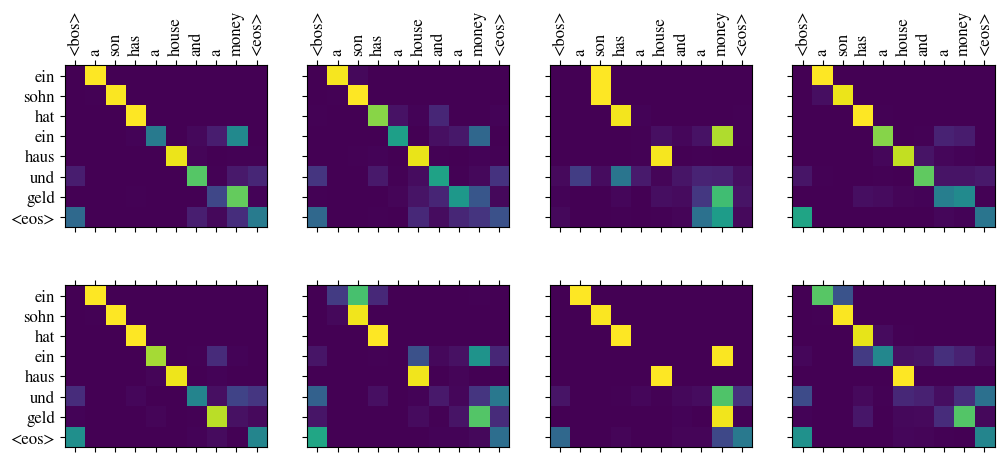

In [306]:
show_result()